In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

import scipy.stats as ss
import plotly.express as px

from scipy import stats
import statsmodels.formula.api as smf 

# Библиотеки для игнорирования предупрждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(
    font_scale =1.5,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,10)}
)

Тестовое:

Вводная:
Трафовые пользователи - пользователи, привлеченные нами в результате рекламных кампаний, т.е. за каждого из них заплачено Х денег
Органические пользователи - пришли в проект сами, т.е. они для нас бесплатные
Есть подозрение, что часть органики приходит от купленного трафа (посредством внутренних виральных инструментов игры, word of mouth или какими-то другими способами).
Количество человек, пришедших с каждого пользователя будем условно называть "k-фактором".


Задача 1: посчитать k-фактор от трафовых пользователей
Задача 2: если k-фактор отличен от 0, посчитать “k-фактор” для денег - т.е. сколько дополнительно денег приходит на каждый потраченный доллар трафового пользователя от привлеченной трафом органики
Задача 3: творческая. Если что-то интересное придет в голову или будет найдена полезная закономерность в данных - это приветствуется.

Цель: правильно оценивать эффективность маркетинговых кампаний

Данные:
ms - канал привлечения (ORGANIC/UA)
cohort - дата привледения
user_cnt - количество новых пользователей
gross - сколько эти пользователи заплатили

Данные вымышлены, особых связей с реальными проектами искать не стоит.

На выходе интересно получить:
1. отчет в любом формате для презентации, pdf, ppt или что-то другое.
2. скрипт py или R по обработке данных и самому анализу

In [3]:
# Загружаем датафрейм

df = pd.read_csv('C:/Users/alexa/TESTING/superlevel/test_data.csv', parse_dates=['cohort'])

In [4]:
df.head(2)

,ms,cohort,user_cnt,gross
0,ORGANIC,2016-01-01,3676,1510
1,UA,2016-01-01,6061,686


In [5]:
# Оформляем датафрейм для удобной работы с ним

df_table_user_cnt = df.pivot(index='cohort', columns='ms', values='user_cnt')

In [6]:
df_table_user_cnt.head(1)

ms,ORGANIC,UA
cohort,,
2016-01-01,3676,6061


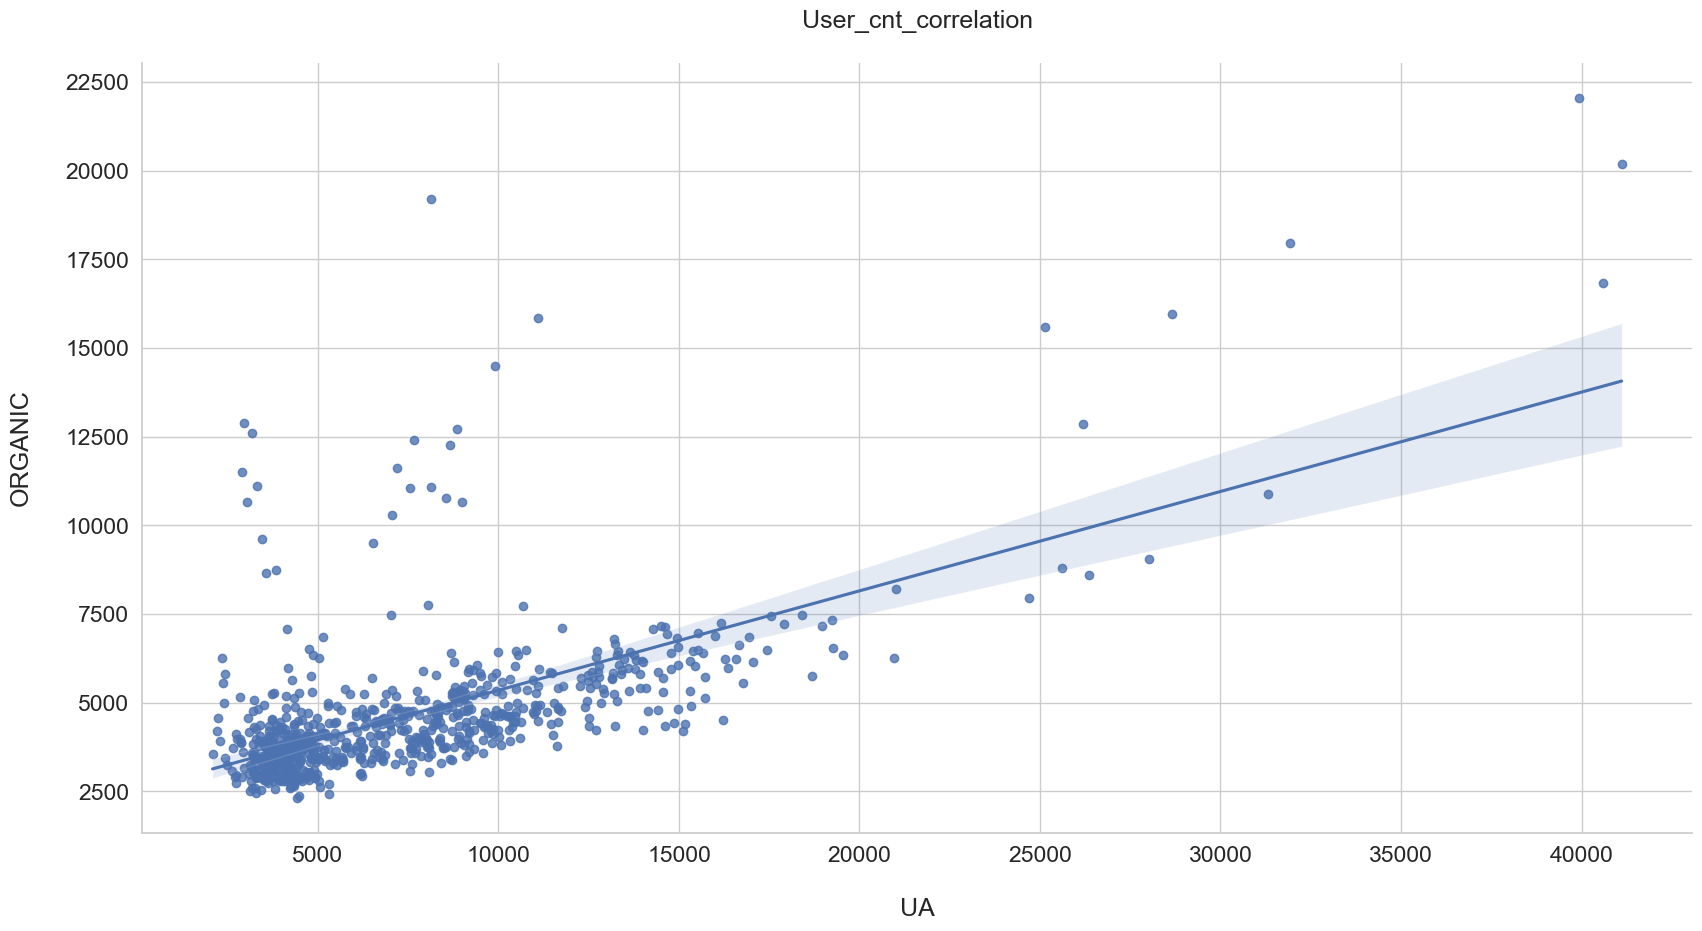

In [7]:
# Используя библиотеку seaborn, построим regplot по нашим данным и посмотрим, как распределена взаимосвязь
# между количеством пользователей, приглашённых в ходе рекламной компании и количеством органических пользователей.

# На графике наблюдается положительная корреляция. Общая закономерность такова, что
# чем больше людей пришло в ходе рекламных компаний тем больше пользователей, пришедших самостоятельно. (что вполне логично)

ax = sns.regplot(data = df_table_user_cnt, x = df_table_user_cnt.UA , y = df_table_user_cnt.ORGANIC)
ax.set_title('User_cnt_correlation\n')
ax.set_ylabel('ORGANIC\n')
ax.set_xlabel('\nUA')
sns.despine()

In [8]:
# Измерим наблюдаемую нами корреляцию
# Наблюдается значительная положительная корреляция

np.corrcoef(df_table_user_cnt.ORGANIC, df_table_user_cnt.UA)

array([[1.        , 0.63561629],
       [0.63561629, 1.        ]])

In [9]:
# Правда ли, что наблюдаемая нами корреляция стат. значима? 
# Используем параметрический метод Пирсона и непараметрический метод Спирмана

ss.pearsonr(df_table_user_cnt.ORGANIC, df_table_user_cnt.UA)

PearsonRResult(statistic=0.635616294295898, pvalue=5.514137060924792e-84)

In [10]:
# Если бы в нашей совокупности не было взаимосвязи между количеством людей, пришедших с рекламной компании, и с 
# количеством людей, пришедших самостоятельно вероятность получить такую корреляцию была бы колоссально мала, судя по p-value
# Вывод: взаимосвязь стат. значима.

ss.spearmanr(df_table_user_cnt.ORGANIC, df_table_user_cnt.UA)

SpearmanrResult(correlation=0.6429175078365315, pvalue=1.7278884581745427e-86)

In [11]:
result_user_cnt = smf.ols('ORGANIC ~ UA', df_table_user_cnt).fit()
print(result_user_cnt.summary())

                            OLS Regression Results                            
Dep. Variable:                ORGANIC   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     494.2
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           5.51e-84
Time:                        02:18:27   Log-Likelihood:                -6457.7
No. Observations:                 731   AIC:                         1.292e+04
Df Residuals:                     729   BIC:                         1.293e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2551.7328    114.839     22.220      0.0

In [12]:
# Согласно t-теста и p-value UA значительно влияет на ORGANIC
# Значение коэффициента детерминации не очень велико, скорее всего вследствие выбросов

# Не стоит обращать внимания на второе примечание, так как у нас одна независимая переменная

ORGANIC_count = 2551.7328 + 0.2801 * UA

In [13]:
print(f"Ответ на задачу №1: k-фактор от трафовых пользователей равен {result_user_cnt.params[1]}")

Ответ на задачу №1: k-фактор от трафовых пользователей равен 0.2801434532592789


In [14]:
# Проедлаем ту же работу с количеством денег, заплаченных пользователями
# Сразу удалю очевидные выбросы, которые могут повлиять на дальнейшую работу
# Оформляем датафрейм для удобной работы с ним

df_table_gross = df.pivot(index='cohort', columns='ms', values='gross')
df_table_gross = df_table_gross.query('ORGANIC < 2500 & UA < 4000')

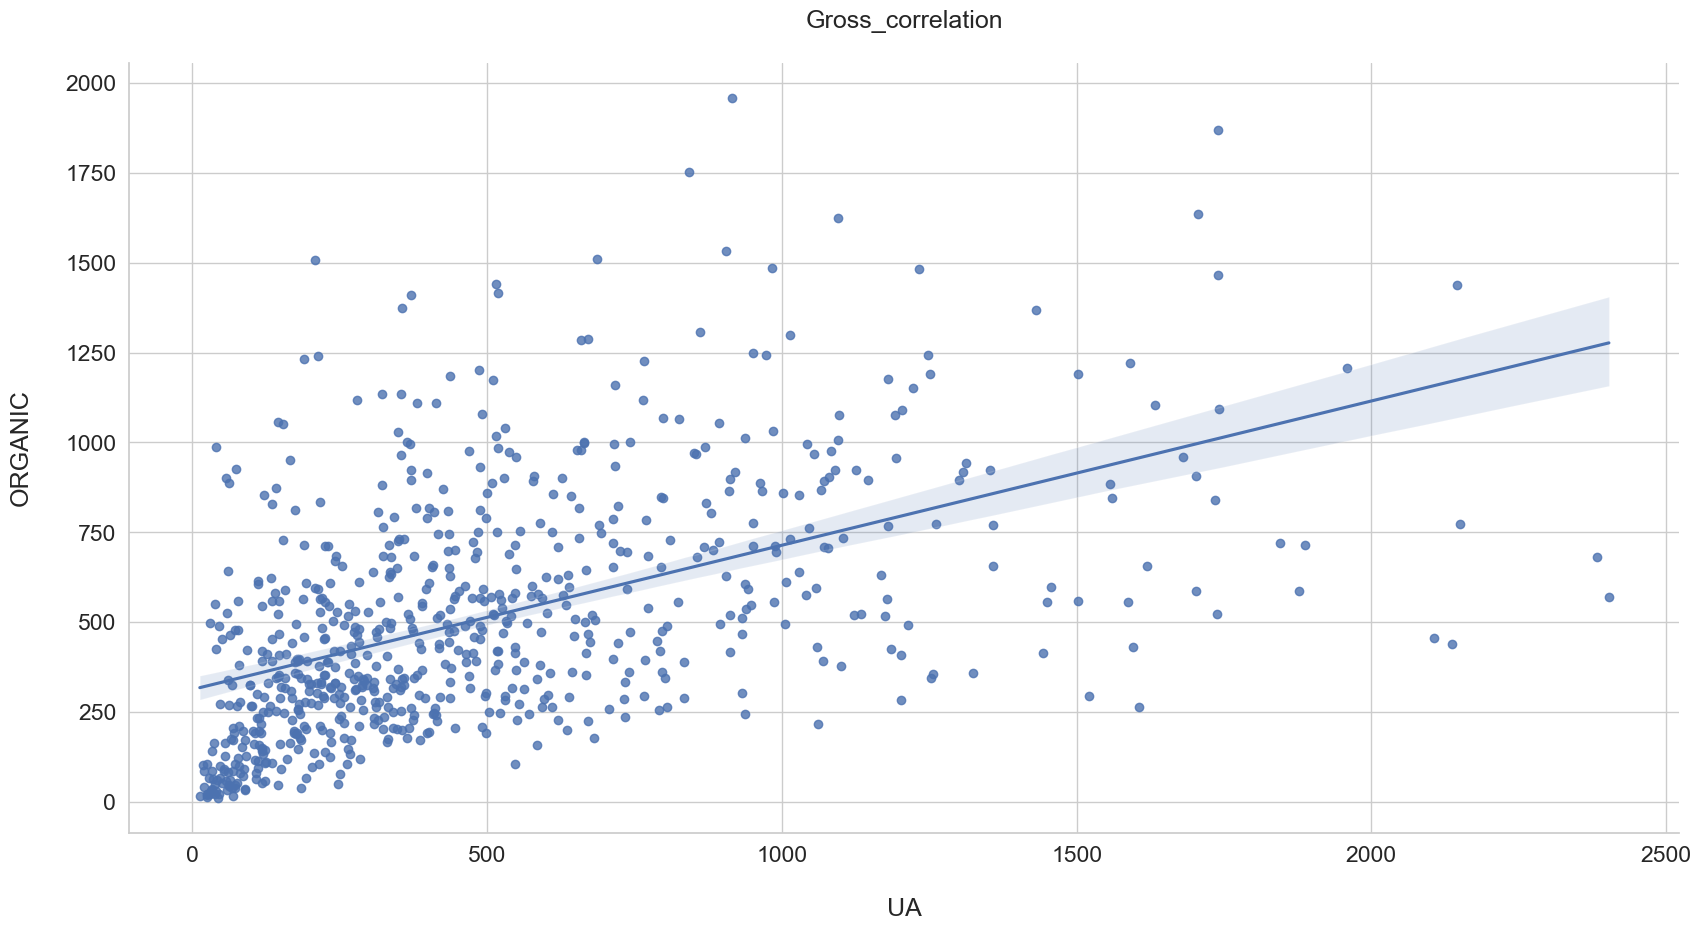

In [15]:
# Используя библиотеку seaborn, построим regplot по нашим данным и посмотрим, как распределена взаимосвязь
# между количеством денег пользователей с рекламной компании и количеством денег, полученных с пользователей, пришедших 
# с органичного трафика.

# На этот раз линейная регрессионная модель предложенная seaborn мне не очень нравится
# Измерим корреляцию теми же методами, а потом создадим другую модель и сравним результаты

ax = sns.regplot(data = df_table_gross, x = 'UA' , y = 'ORGANIC')
ax.set_title('Gross_correlation\n')
ax.set_ylabel('ORGANIC\n')
ax.set_xlabel('\nUA')
sns.despine()

In [16]:
# Измерим наблюдаемую нами корреляцию
# Наблюдается положительная корреляция

np.corrcoef(df_table_gross.ORGANIC, df_table_gross.UA)

array([[1.        , 0.50593583],
       [0.50593583, 1.        ]])

In [17]:
# Правда ли, что наблюдаемая нами корреляция стат. значима? 
# Используем параметрический метод Пирсона и непараметрический метод Спирмана

ss.pearsonr(df_table_gross.ORGANIC, df_table_gross.UA)

PearsonRResult(statistic=0.5059358328555786, pvalue=1.421071350736113e-48)

In [18]:
# В данном случае я бы полагался на непараметрику, потому что распределение ошибок ненормально
# Вывод: взаимосвязь стат. значима.

ss.spearmanr(df_table_gross.ORGANIC, df_table_gross.UA)

SpearmanrResult(correlation=0.5861496707378527, pvalue=2.193981823107029e-68)

In [19]:
result_gross = smf.ols('ORGANIC ~ UA', df_table_gross).fit()
print(result_gross.summary())

                            OLS Regression Results                            
Dep. Variable:                ORGANIC   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     249.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           1.42e-48
Time:                        02:18:27   Log-Likelihood:                -5157.6
No. Observations:                 728   AIC:                         1.032e+04
Df Residuals:                     726   BIC:                         1.033e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    312.7392     16.615     18.822      0.0

In [20]:
# Согласно t-теста и p-value UA значительно влияет на ORGANIC
# Значение коэффициента детерминации низкое, необходимо попробовать другую регрессионную модель

# Не стоит обращать внимания на второе примечание, так как у нас одна независимая переменная

ORGANIC_gross = 312.7392 + 0.4012 * UA_gross

In [21]:
print(f"Ответ на задачу №2: g-фактор от трафовых пользователей равен {result_gross.params[1]} (но это неточно :) )")

Ответ на задачу №2: g-фактор от трафовых пользователей равен 0.4012450132011478 (но это неточно :) )


In [22]:
# Попробуем преобразовать наши данные, взяв логарифм исходных интересующих величин

df_table_gross_log = df_table_gross
df_table_gross_log['ln_ORGANIC'] = df_table_gross_log['ORGANIC'].apply(np.log)
df_table_gross_log['ln_UA'] = df_table_gross_log['UA'].apply(np.log)

In [23]:
# Объявим модель и обучим её, запишем результаты

lm_gross_log = smf.ols('ln_ORGANIC ~ ln_UA', data=df_table_gross_log)
res_gross_log = lm_gross_log.fit()

In [24]:
# Воспользуемся np.linspace для адекатного отображения регрессионной линии
# В дальнейшем лучше пользоваться предикшенами по этой модели, заключив нужные данные в массив

xs = np.linspace(0, 2500, 728)
X_new = pd.DataFrame({'ln_UA': np.log(xs)})

preds = np.exp(res_gross_log.predict(X_new))

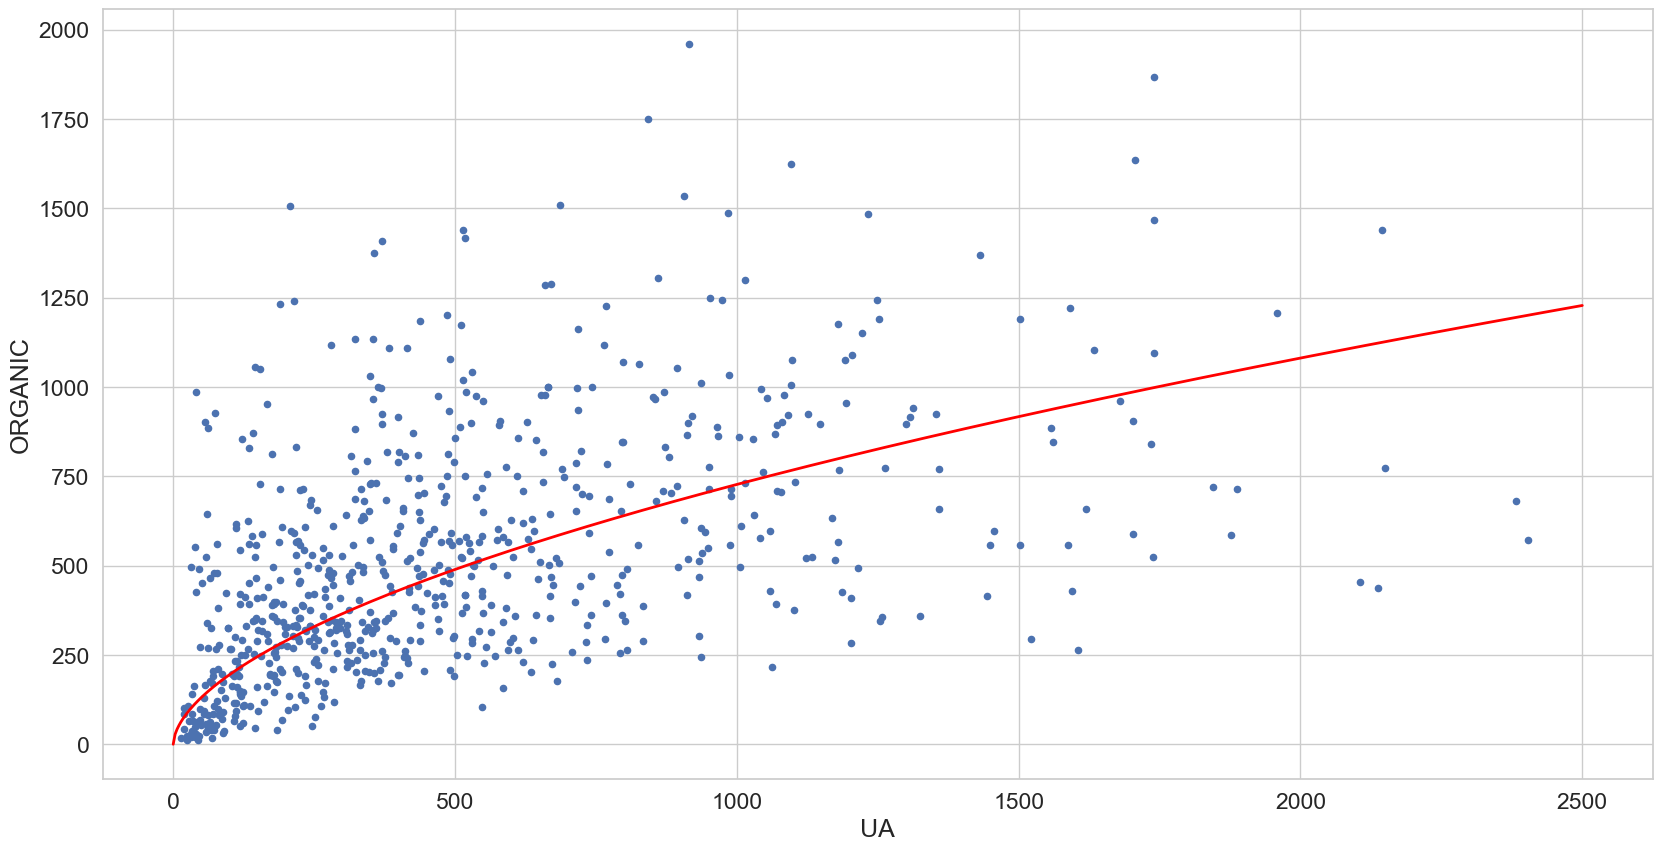

In [25]:
# Строим scatterplot

df_table_gross_log.plot(kind='scatter', x='UA', y='ORGANIC')

# Строим линию регрессии

plt.plot(xs, preds, c='red', linewidth=2)
plt.show()

In [26]:
print(res_gross_log.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_ORGANIC   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     544.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           2.38e-90
Time:                        02:18:27   Log-Likelihood:                -705.35
No. Observations:                 728   AIC:                             1415.
Df Residuals:                     726   BIC:                             1424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6385      0.145     18.233      0.0

In [27]:
# Судя по R^2 данная модель лучше описывает взаимосвязь наших переменных

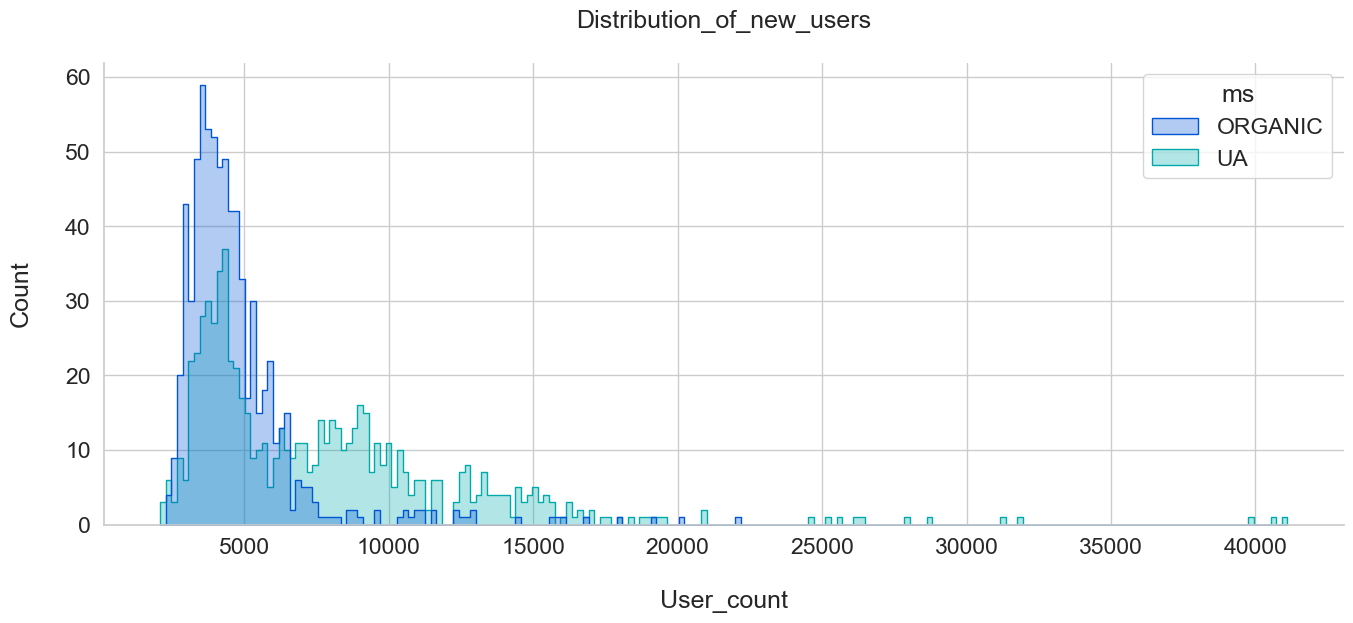

In [28]:
# Построим графики и визульно оценим выборки
# Распределение сильно отличается от нормального

plt.figure(figsize=(16,6))
ax = sns.histplot(data = df, 
                  x = 'user_cnt', 
                  hue = 'ms', 
                  palette = 'winter',
                  alpha = 0.3,
                  element = 'step',
                  bins = 200)

ax.set_title('Distribution_of_new_users\n')
ax.set_ylabel('Count\n')
ax.set_xlabel('\nUser_count')
sns.despine()

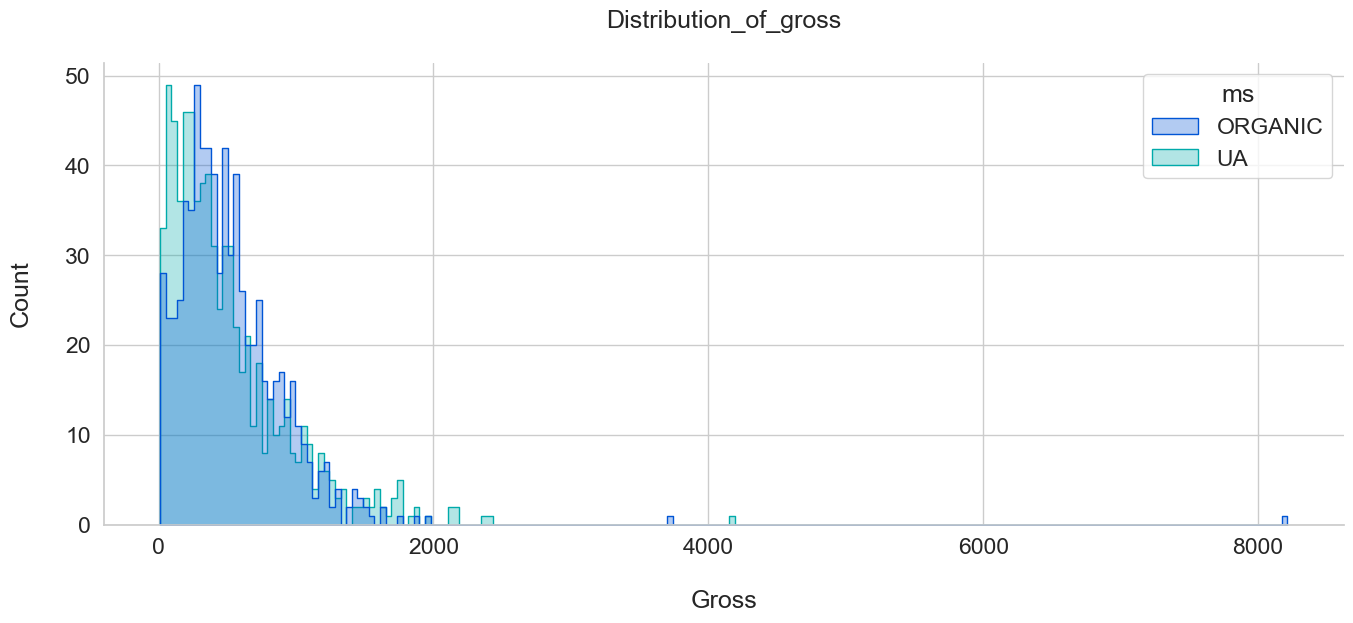

In [29]:
plt.figure(figsize=(16,6))
ax = sns.histplot(data = df, 
              x = 'gross', 
              hue = 'ms', 
              palette = 'winter',
              alpha = 0.3,
              element = 'step',
              bins = 200)

ax.set_title('Distribution_of_gross\n')
ax.set_ylabel('Count\n')
ax.set_xlabel('\nGross')
sns.despine()

In [30]:
# Построим график, описывающий рост количества новых пользователей с течением времени
# Для этого займёмся предподготовкой исходный данных

In [31]:
df_user_cnt_roll_org = df.query('ms == "ORGANIC"')
df_user_cnt_roll_org['user_cnt_rol'] = df_user_cnt_roll_org['user_cnt'].rolling(20).mean()

In [32]:
df_user_cnt_roll_ua = df.query('ms == "UA"')
df_user_cnt_roll_ua['user_cnt_rol'] = df_user_cnt_roll_ua['user_cnt'].rolling(20).mean()

In [33]:
concat_1 = pd.concat([df_user_cnt_roll_org, df_user_cnt_roll_ua])

In [34]:
df_user_cnt_roll_mean_user = df_table_user_cnt.copy()
df_user_cnt_roll_mean_user['mean_user'] = (df_user_cnt_roll_mean_user.ORGANIC + df_user_cnt_roll_mean_user.UA) / 2

In [35]:
df_stack = df_user_cnt_roll_mean_user.unstack()
df_stack = df_stack.to_frame().rename(columns={0: 'user_cnt'}).reset_index()

In [36]:
df_user_cnt_roll_mean = df_stack.query('ms == "mean_user"')

In [37]:
df_user_cnt_roll_mean['user_cnt_rol'] = df_user_cnt_roll_mean['user_cnt'].rolling(20).mean()

In [38]:
concat2 = pd.concat([concat_1, df_user_cnt_roll_mean])

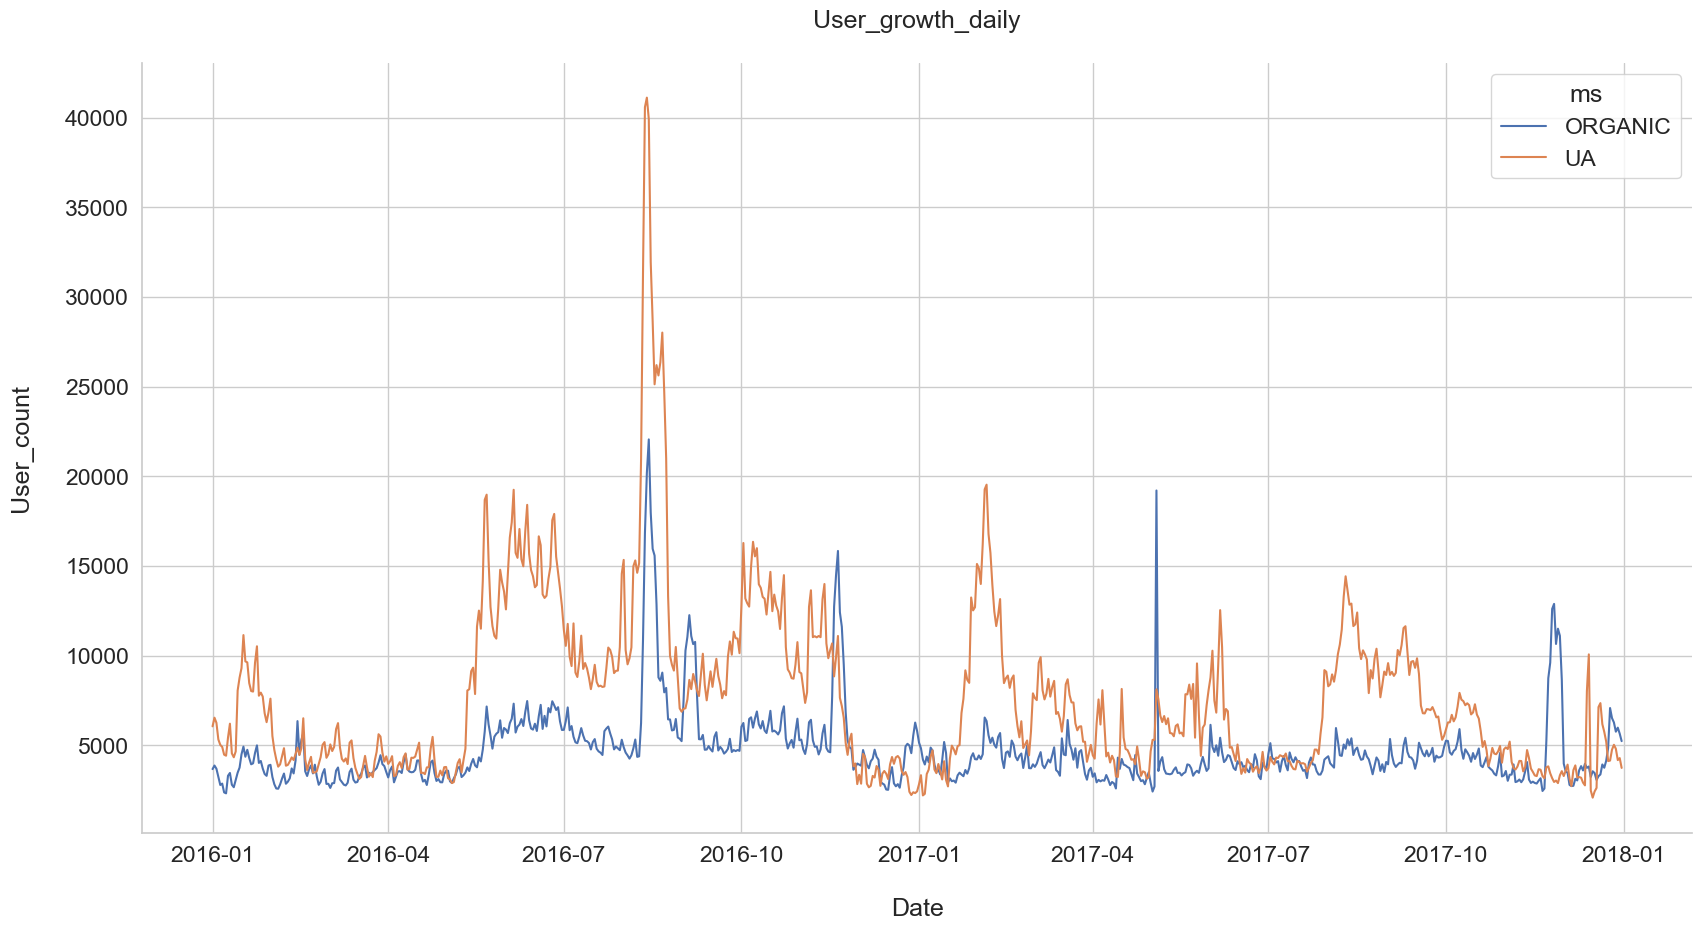

In [39]:
# График не очень удобен для интерпретации закономерностей, поэтому используем скользящее среднее

ax = sns.lineplot(data=df, x="cohort", y="user_cnt", hue="ms")
ax.set_title('User_growth_daily\n')
ax.set_ylabel('User_count\n')
ax.set_xlabel('\nDate')
sns.despine()

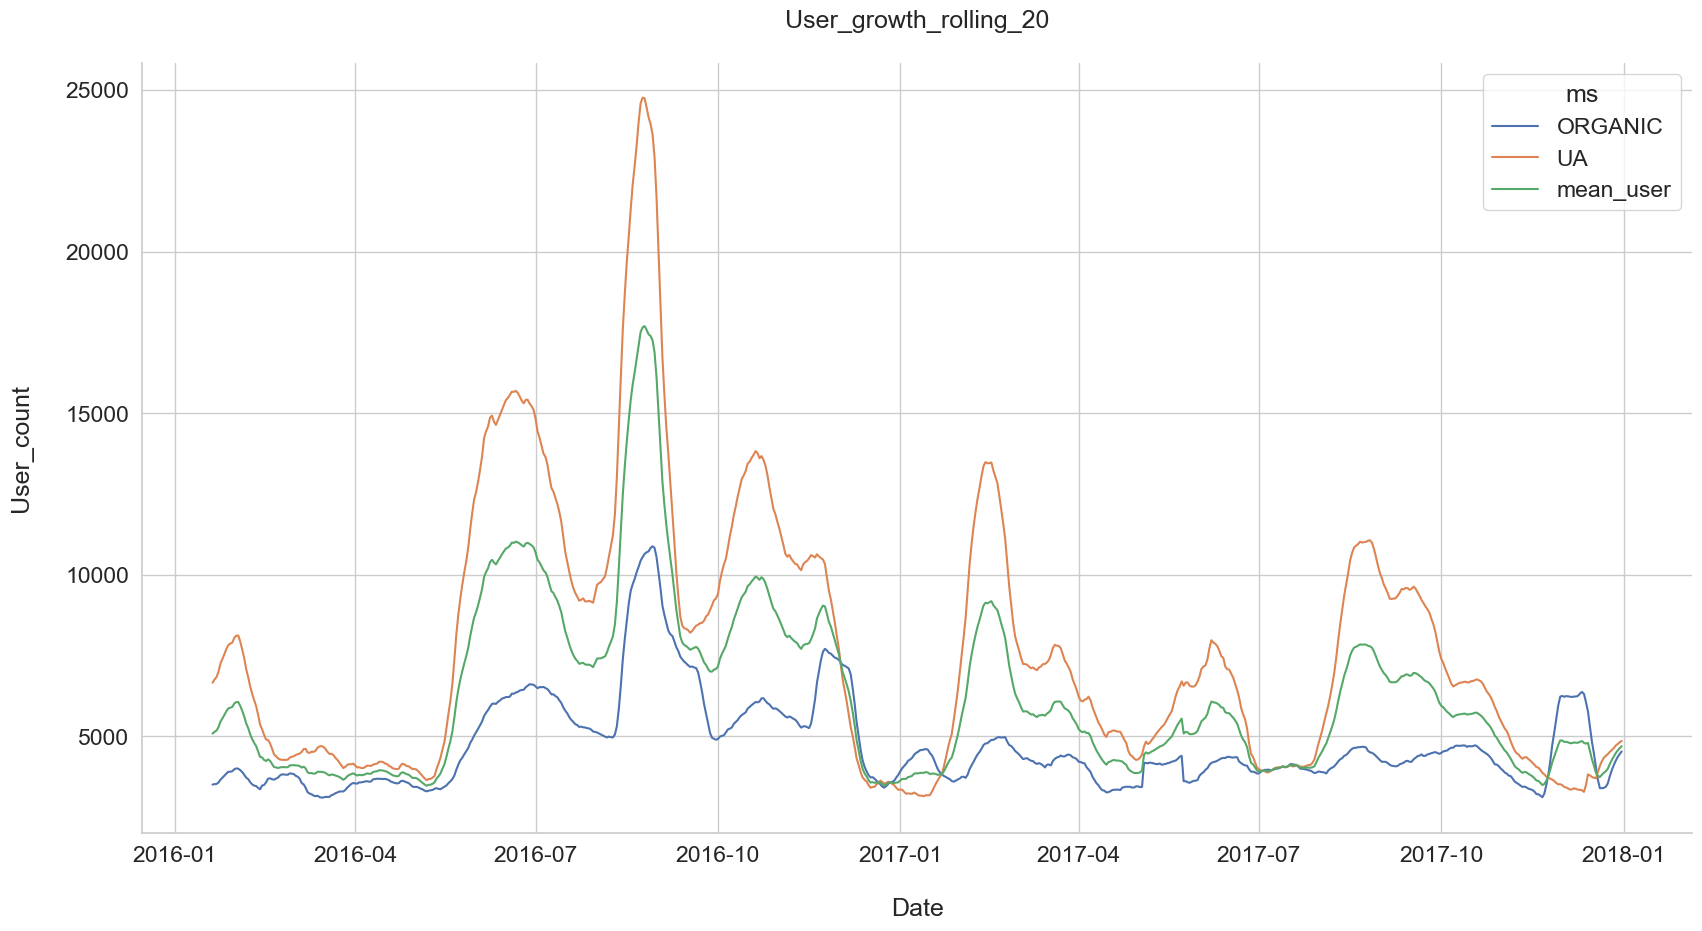

In [40]:
# График скользящего среднего по новым юзерам с окном в 20, интерпретировать стало значительно проще
# Видны общие тенденции, особенно с мая 2016 по декабрь 2016

ax = sns.lineplot(data=concat2, x="cohort", y="user_cnt_rol", hue="ms")
ax.set_title('User_growth_rolling_20\n')
ax.set_ylabel('User_count\n')
ax.set_xlabel('\nDate')
sns.despine()

In [41]:
# Проделаем ту же самую работу, с показателями потраченных пользователями денег

df_gross_roll_org = df.query('ms == "ORGANIC"')
df_gross_roll_org['gross_rol'] = df_user_cnt_roll_org['gross'].rolling(20).mean()

In [42]:
df_gross_roll_ua = df.query('ms == "UA"')
df_gross_roll_ua['gross_rol'] = df_gross_roll_ua['gross'].rolling(20).mean()

In [43]:
concat_3 = pd.concat([df_gross_roll_org, df_gross_roll_ua]) 

In [44]:
df_gross_roll_mean_user = df_table_gross.copy()
df_gross_roll_mean_user['mean_user'] = (df_gross_roll_mean_user.ORGANIC + df_gross_roll_mean_user.UA) / 2

In [45]:
df_stack_gross = df_gross_roll_mean_user.unstack()
df_stack_gross = df_stack_gross.to_frame().rename(columns={0: 'gross'}).reset_index()

In [46]:
df_gross_roll_mean = df_stack_gross.query('ms == "mean_user"')

In [47]:
df_gross_roll_mean['gross_rol'] = df_gross_roll_mean['gross'].rolling(20).mean()

In [48]:
concat4 = pd.concat([concat_3, df_gross_roll_mean])

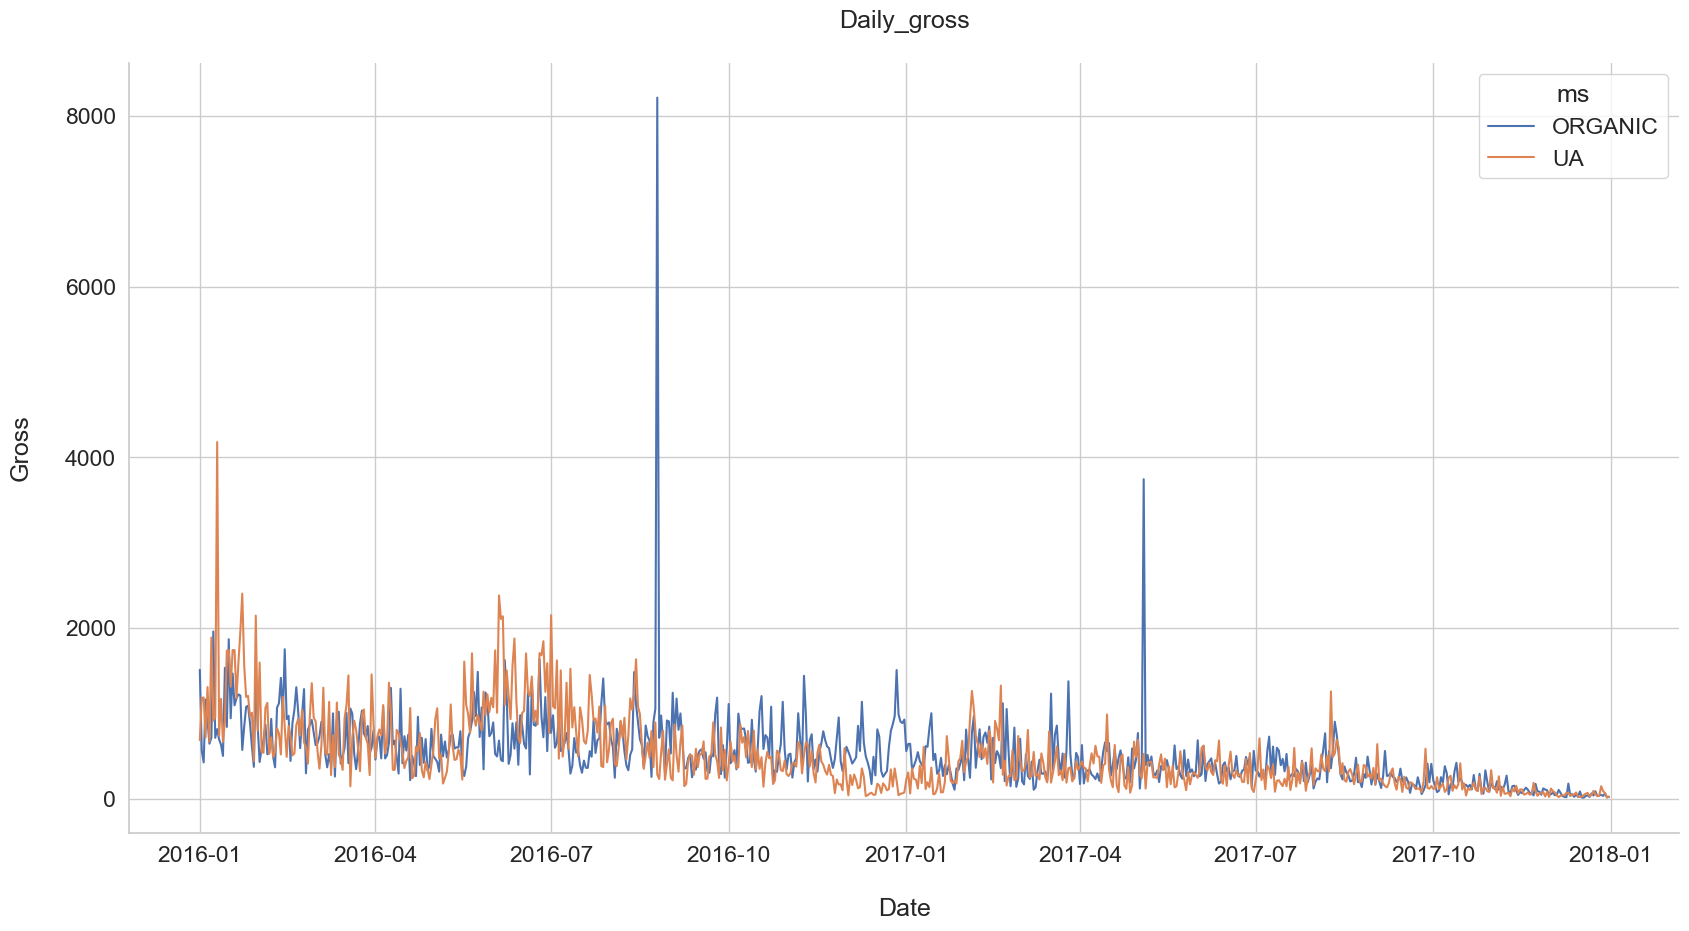

In [49]:
# График практически не интрепретируем. Для себя можно выделить два выброса, найти причину которых, мне не хватает данных.

ax = sns.lineplot(data=df, x="cohort", y="gross", hue="ms")
ax.set_title('Daily_gross\n')
ax.set_ylabel('Gross\n')
ax.set_xlabel('\nDate')
sns.despine()

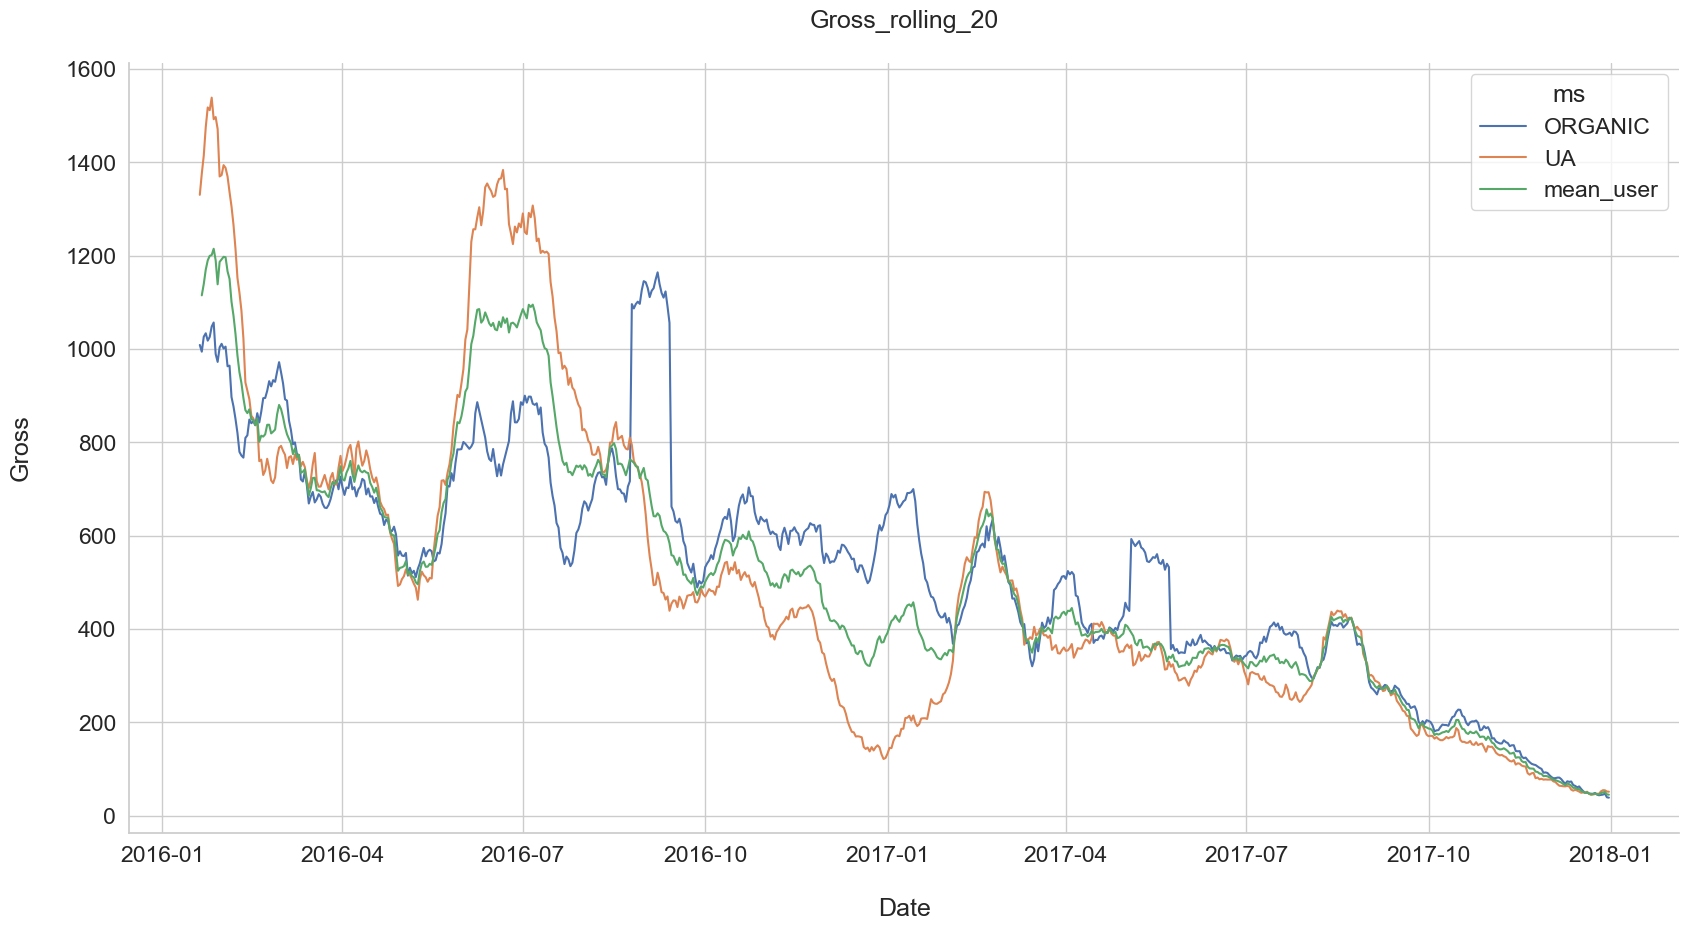

In [50]:
# График потраченных средних со скользящим средним с окном в 20, насколько график стал хорош.
# Казна пустеет, Ваша Светлость :(

ax = sns.lineplot(data=concat4, x="cohort", y="gross_rol", hue="ms")
ax.set_title('Gross_rolling_20\n')
ax.set_ylabel('Gross\n')
ax.set_xlabel('\nDate')
sns.despine()

In [51]:
# Посчитаем кумулятивную сумму, построим график, сделаем выводы.

df_gross_org = df.query('ms == "ORGANIC"')
df_gross_org['gross_sum'] = df_gross_org['gross'].cumsum()

In [52]:
df_gross_UA = df.query('ms == "UA"')
df_gross_UA['gross_sum'] = df_gross_UA['gross'].cumsum()

In [53]:
concat5 = pd.concat([df_gross_org, df_gross_UA])

In [54]:
concat5

,ms,cohort,user_cnt,gross,gross_sum
0,ORGANIC,2016-01-01,3676,1510,1510
3,ORGANIC,2016-01-02,3875,565,2075
4,ORGANIC,2016-01-03,3699,425,2500
6,ORGANIC,2016-01-04,3237,1161,3661
8,ORGANIC,2016-01-05,2792,917,4578
...,...,...,...,...,...
1453,UA,2017-12-27,5032,146,368851
1455,UA,2017-12-28,4809,89,368940
1457,UA,2017-12-29,4180,65,369005
1459,UA,2017-12-30,4291,13,369018


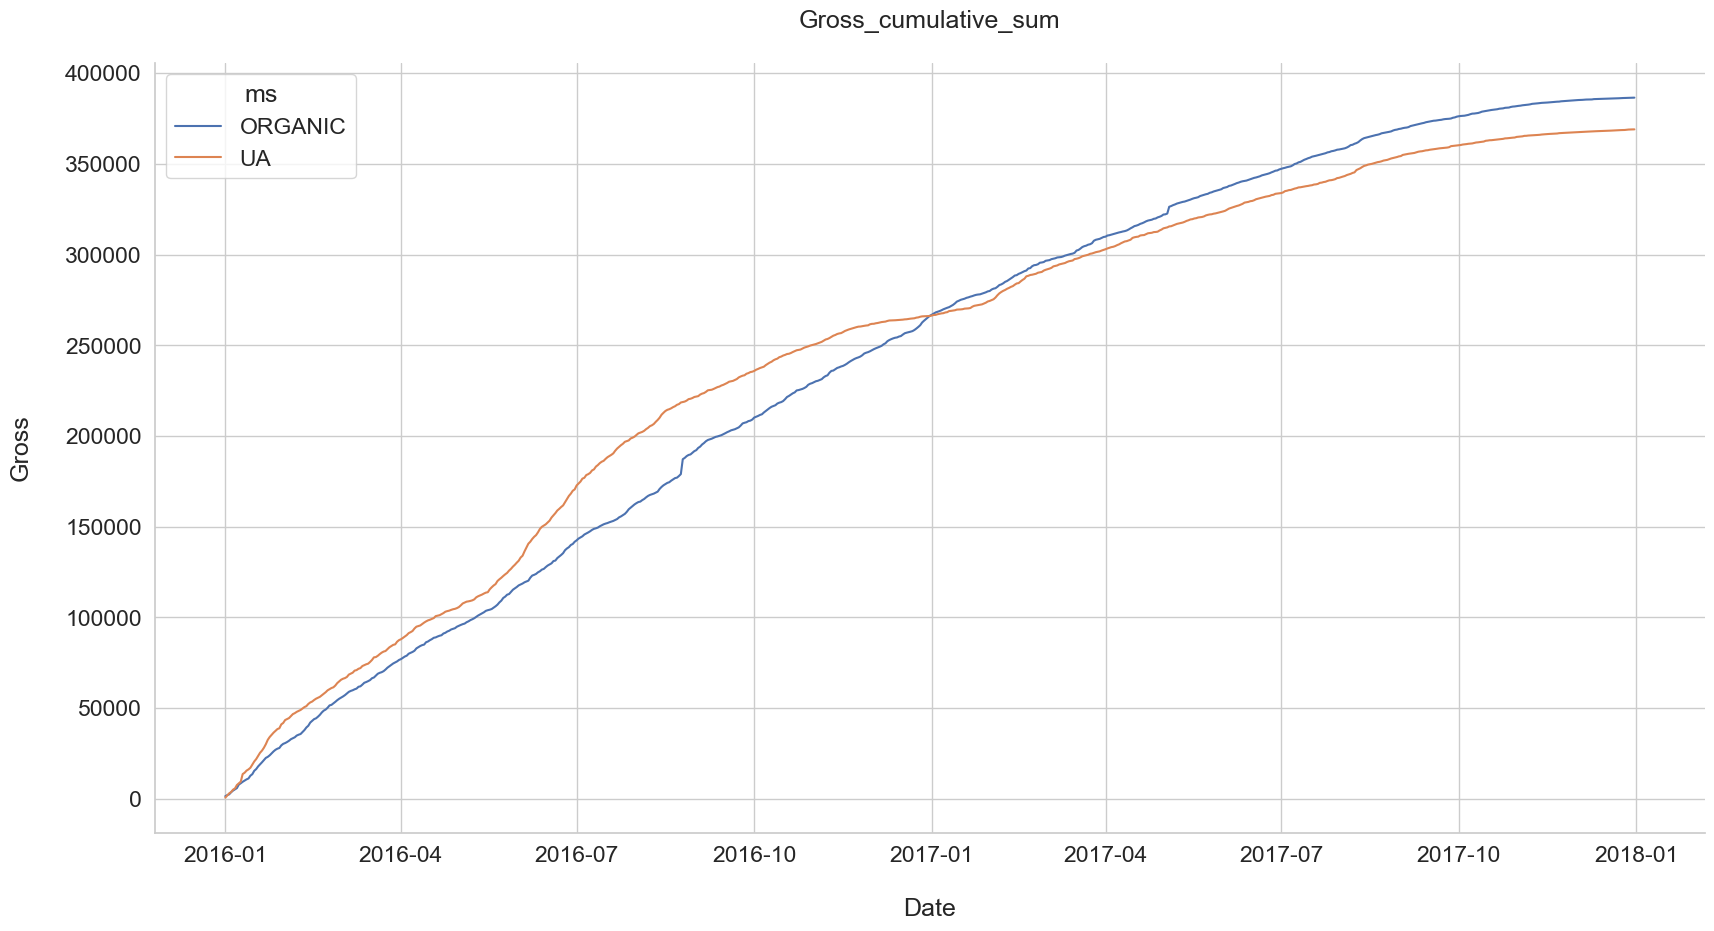

In [55]:
# Трафик привлечённый в ходе рекламной компании и органический трафик принесли в компанию примерно одинкаовое количество денег

ax = sns.lineplot(data=concat5, x="cohort", y="gross_sum", hue="ms")
ax.set_title('Gross_cumulative_sum\n')
ax.set_ylabel('Gross\n')
ax.set_xlabel('\nDate')
sns.despine()

In [56]:
# Проведём инфографику по днням недели

df_weekday = df

In [57]:
df_weekday['cohort'] =  df_weekday['cohort'].dt.weekday

In [58]:
df_weekday_org = df_weekday.query('ms == "ORGANIC"') \
                           .groupby('cohort', as_index=False) \
                           .agg({'user_cnt': 'sum', 'gross': 'sum'}) \
                           .rename(columns={'cohort': 'weekday'})

In [59]:
days = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 5: 'saturday', 6: 'sunday'}

In [60]:
df_weekday_org['weekday'] = [days[i] for i in list(df_weekday_org.weekday)]

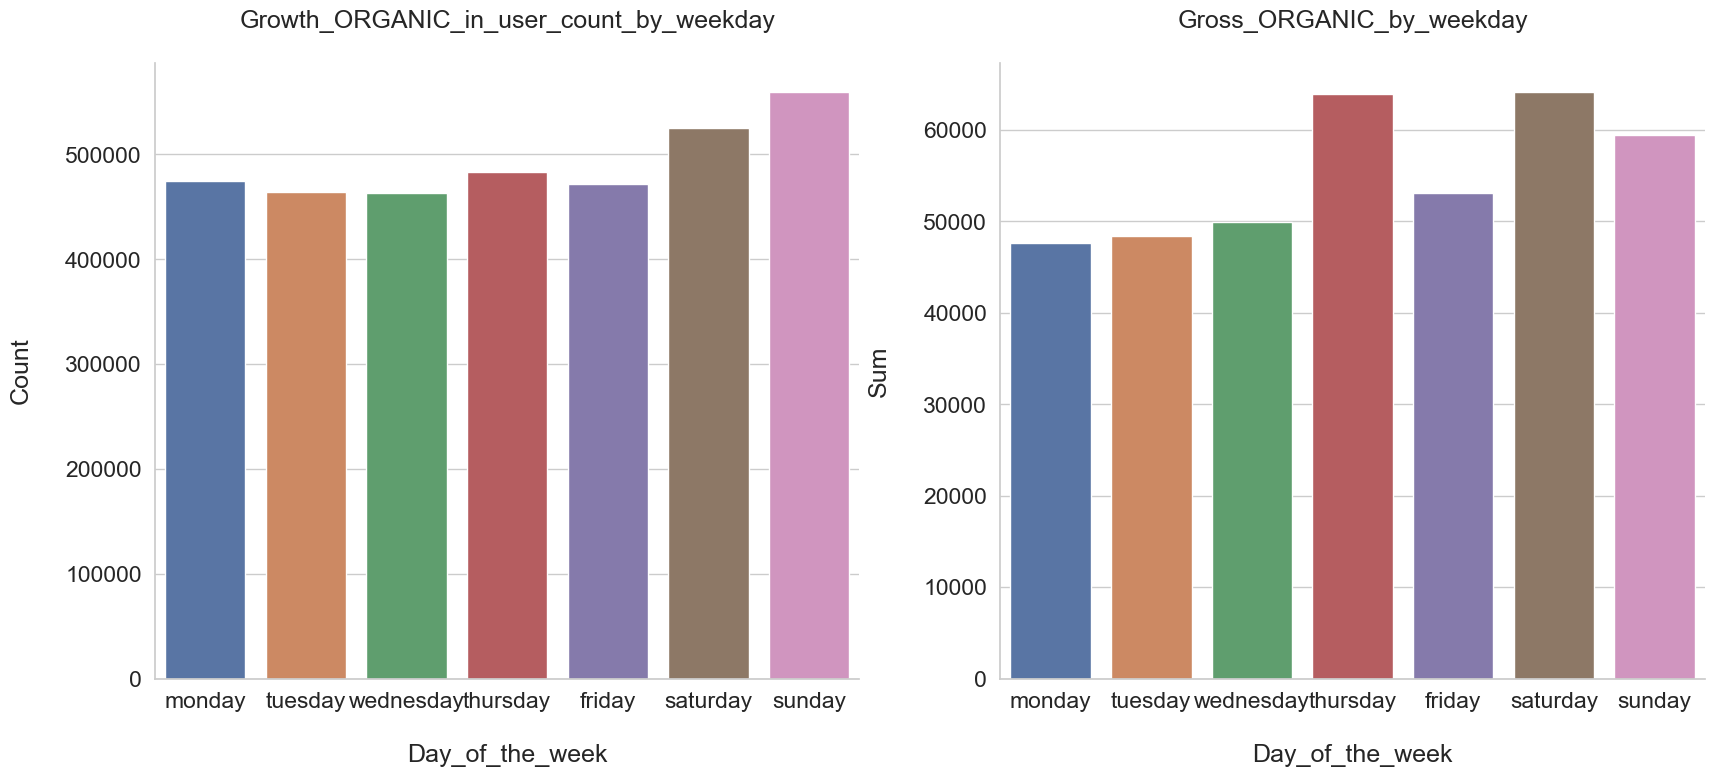

In [61]:
# По органичному трафику наибольший рост пользователей приходился на выходные дни
# Больше всего денег вливали юзеры в четверг и в субботу

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(data=df_weekday_org, y='user_cnt', x='weekday', ax= axs[0])
axs[0].set(title='Growth_ORGANIC_in_user_count_by_weekday\n', xlabel='\nDay_of_the_week', ylabel='Count\n')

sns.barplot(data=df_weekday_org, y='gross', x='weekday', ax= axs[1])
axs[1].set(title='Gross_ORGANIC_by_weekday\n', xlabel='\nDay_of_the_week', ylabel='Sum\n')
sns.despine()

In [62]:
df_weekday_ua = df_weekday.query('ms == "UA"') \
                          .groupby('cohort', as_index=False) \
                          .agg({'user_cnt': 'sum', 'gross': 'sum'}) \
                          .rename(columns={'cohort': 'weekday'})

In [63]:
days = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 5: 'saturday', 6: 'sunday'}

In [64]:
df_weekday_ua['weekday'] = [days[i] for i in list(df_weekday_ua.weekday)]

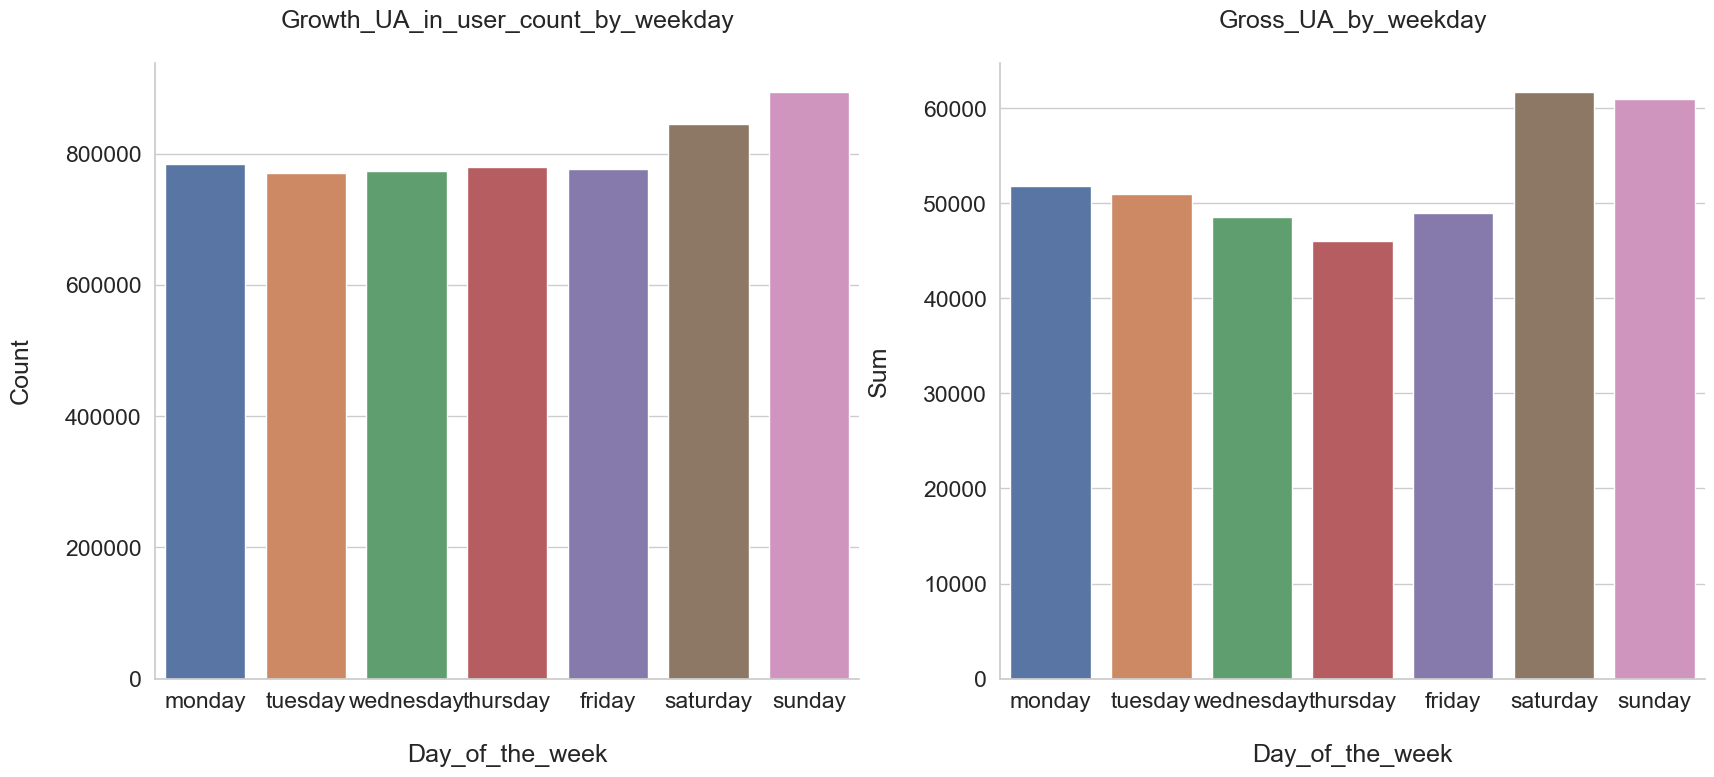

In [65]:
# По трафику с рекламной компании всё стабильно, наибольший прирост обоих показателей приходился на выходные дни

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(data=df_weekday_ua, y='user_cnt', x='weekday', ax= axs[0])
axs[0].set(title='Growth_UA_in_user_count_by_weekday\n', xlabel='\nDay_of_the_week', ylabel='Count\n')

sns.barplot(data=df_weekday_ua, y='gross', x='weekday', ax= axs[1])
axs[1].set(title='Gross_UA_by_weekday\n', xlabel='\nDay_of_the_week', ylabel='Sum\n')
sns.despine()

### ОБЩИЙ ВЫВОД

ЗАДАЧА №1.Ответ: 

k-фактор от трафовых пользователей равен 0.2801434532592789.

ЗАДАЧА №2.Ответ: 

g-фактор от трафовых пользователей равен 0.4012450132011478. (но это неточно, так как сложно описать регрессию по показателю траты денег прямой линией. Лучше пользоваться предикшен моделью, основанной на предобработке данных путём логарифмирования)

ЗАДАЧА №3.Ответ: 

Построены графики:

* Распределения показателей прироста юзеров и потраченных денег. Как и ожидалось они отличны от нормального распределения.

Были построены линейные графики:

* Дневной прирост пользователей по группам;
* Прирост пользователей со скользящим средним с окном в 20. Были замечены общие тенденции графиков;

* Дневные траты пользователей по группам;
* Траты пользователей со скользящим средним с окном в 20. Обнаружена тенденция стабильного снижения потраченных ими денег;

* График с кумулятивной суммой потраченных пользователями денег по группам. Обнаружено, что обе группы потратили примерно одинаковое количество денег;

Были построены барплоты:

* По сумме прироста пользователей и потраченных ими денег по дням недели. Обнаружены дни, в которых значения показателей больше чем обычно.
